Response — 1, если клиент принял предложение в последней кампании, 0 — в противном случае
ID — уникальный идентификатор каждого клиента
Year_Birth — возраст клиента
Complain — 1, если клиент жаловался в течение последних 2 лет
Dt_Customer — дата регистрации клиента в компании
Education — уровень образования клиента
Marital — семейное положение клиента
Kidhome — количество маленьких детей в семье клиента
Teenhome — количество подростков в семье клиента
Income — годовой доход семьи клиента
MntFishProducts — сумма, потраченная на рыбные продукты за последние 2 года
MntMeatProducts — сумма, потраченная на мясные продукты за последние 2 года
MntFruits — сумма, потраченная на фрукты за последние 2 года
MntSweetProducts — сумма, потраченная на сладости за последние 2 года
MntWines — сумма, потраченная на вино за последние 2 года
MntGoldProds — сумма, потраченная на изделия из золота за последние 2 года
NumDealsPurchases — количество покупок, совершенных со скидкой
NumCatalogPurchases — количество покупок, совершенных с помощью каталога (покупка товаров с доставкой по почте)
NumStorePurchases — количество покупок, совершенных непосредственно в магазинах
NumWebPurchases — количество покупок, совершенных через веб-сайт компании
NumWebVisitsMonth — количество посещений сайта компании за последний месяц
Recency — количество дней с момента последней покупки

In [4]:
import os
os.environ["OMP_NUM_THREADS"] = "8"


In [5]:
import plotly.express as px
import pandas as pd
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score
import seaborn as sns
from sklearn import datasets
%matplotlib inline

In [6]:
df = pd.read_csv("superstore_data.csv")
RAND = 10

In [7]:
df.head()

Id  Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
0   1826        1970  Graduation       Divorced  84835.0        0         0   
1      1        1961  Graduation         Single  57091.0        0         0   
2  10476        1958  Graduation        Married  67267.0        0         1   
3   1386        1967  Graduation       Together  32474.0        1         1   
4   5371        1989  Graduation         Single  21474.0        1         0   

  Dt_Customer  Recency  MntWines  ...  MntFishProducts  MntSweetProducts  \
0   6/16/2014        0       189  ...              111               189   
1   6/15/2014        0       464  ...                7                 0   
2   5/13/2014        0       134  ...               15                 2   
3   11/5/2014        0        10  ...                0                 0   
4    8/4/2014        0         6  ...               11                 0   

   MntGoldProds  NumDealsPurchases  NumWebPurchases  NumCatalogPurchases  \
0           218                  1                4                    4   
1            37                  1                7                    3   
2            30                  1                3                    2   
3             0                  1                1                    0   
4            34                  2                3                    1   

   NumStorePurchases  NumWebVisitsMonth  Response  Complain  
0                  6                  1         1         0  
1                  7                  5         1         0  
2                  5                  2         0         0  
3                  2                  7         0         0  
4                  2                  7         1         0  

[5 rows x 22 columns]

In [8]:
cols = [col for col in df.columns]
cols

['Id',
 'Year_Birth',
 'Education',
 'Marital_Status',
 'Income',
 'Kidhome',
 'Teenhome',
 'Dt_Customer',
 'Recency',
 'MntWines',
 'MntFruits',
 'MntMeatProducts',
 'MntFishProducts',
 'MntSweetProducts',
 'MntGoldProds',
 'NumDealsPurchases',
 'NumWebPurchases',
 'NumCatalogPurchases',
 'NumStorePurchases',
 'NumWebVisitsMonth',
 'Response',
 'Complain']

In [9]:
df.columns = [
    'ID',                            # Id
    'Год_рождения',                 # Year_Birth
    'Образование',                  # Education
    'Семейное_положение',           # Marital_Status
    'Доход',                        # Income
    'Детей_дома',                   # Kidhome
    'Подростков_дома',              # Teenhome
    'Дата_регистрации',             # Dt_Customer
    'Давность_покупки',             # Recency
    'Затраты_на_вино',              # MntWines
    'Затраты_на_фрукты',            # MntFruits
    'Затраты_на_мясо',              # MntMeatProducts
    'Затраты_на_рыбу',              # MntFishProducts
    'Затраты_на_сладости',          # MntSweetProducts
    'Затраты_на_золото',            # MntGoldProds
    'Покупки_по_акции',             # NumDealsPurchases
    'Покупки_в_интернете',          # NumWebPurchases
    'Покупки_по_каталогу',          # NumCatalogPurchases
    'Покупки_в_магазине',           # NumStorePurchases
    'Покупки_через_сайт_в_месяц',   # NumWebVisitsMonth
    'Отклик',                       # Response
    'Жалоба'                        # Complain
]

In [10]:
df['Образование'].value_counts()

Образование
Graduation    1127
PhD            486
Master         370
2n Cycle       203
Basic           54
Name: count, dtype: int64

In [11]:
education_translation = {
    'Graduation': 'Высшее образование',
    'PhD': 'Аспирантура (PhD)',
    'Master': 'Магистратура',
    '2n Cycle': 'Незаконченное высшее',
    'Basic': 'Среднее образование'
}
df['Образование'] = df['Образование'].replace(education_translation)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          2240 non-null   int64  
 1   Год_рождения                2240 non-null   int64  
 2   Образование                 2240 non-null   object 
 3   Семейное_положение          2240 non-null   object 
 4   Доход                       2216 non-null   float64
 5   Детей_дома                  2240 non-null   int64  
 6   Подростков_дома             2240 non-null   int64  
 7   Дата_регистрации            2240 non-null   object 
 8   Давность_покупки            2240 non-null   int64  
 9   Затраты_на_вино             2240 non-null   int64  
 10  Затраты_на_фрукты           2240 non-null   int64  
 11  Затраты_на_мясо             2240 non-null   int64  
 12  Затраты_на_рыбу             2240 non-null   int64  
 13  Затраты_на_сладости         2240 

In [13]:
df.dropna(inplace=True)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2216 entries, 0 to 2239
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          2216 non-null   int64  
 1   Год_рождения                2216 non-null   int64  
 2   Образование                 2216 non-null   object 
 3   Семейное_положение          2216 non-null   object 
 4   Доход                       2216 non-null   float64
 5   Детей_дома                  2216 non-null   int64  
 6   Подростков_дома             2216 non-null   int64  
 7   Дата_регистрации            2216 non-null   object 
 8   Давность_покупки            2216 non-null   int64  
 9   Затраты_на_вино             2216 non-null   int64  
 10  Затраты_на_фрукты           2216 non-null   int64  
 11  Затраты_на_мясо             2216 non-null   int64  
 12  Затраты_на_рыбу             2216 non-null   int64  
 13  Затраты_на_сладости         2216 non-n

In [15]:
df['Давность_покупки'].describe()

count    2216.000000
mean       49.012635
std        28.948352
min         0.000000
25%        24.000000
50%        49.000000
75%        74.000000
max        99.000000
Name: Давность_покупки, dtype: float64

In [16]:
df.describe()

ID  Год_рождения          Доход   Детей_дома  \
count   2216.000000   2216.000000    2216.000000  2216.000000   
mean    5588.353339   1968.820397   52247.251354     0.441787   
std     3249.376275     11.985554   25173.076661     0.536896   
min        0.000000   1893.000000    1730.000000     0.000000   
25%     2814.750000   1959.000000   35303.000000     0.000000   
50%     5458.500000   1970.000000   51381.500000     0.000000   
75%     8421.750000   1977.000000   68522.000000     1.000000   
max    11191.000000   1996.000000  666666.000000     2.000000   

       Подростков_дома  Давность_покупки  Затраты_на_вино  Затраты_на_фрукты  \
count      2216.000000       2216.000000      2216.000000        2216.000000   
mean          0.505415         49.012635       305.091606          26.356047   
std           0.544181         28.948352       337.327920          39.793917   
min           0.000000          0.000000         0.000000           0.000000   
25%           0.000000         24.000000        24.000000           2.000000   
50%           0.000000         49.000000       174.500000           8.000000   
75%           1.000000         74.000000       505.000000          33.000000   
max           2.000000         99.000000      1493.000000         199.000000   

       Затраты_на_мясо  Затраты_на_рыбу  Затраты_на_сладости  \
count      2216.000000      2216.000000          2216.000000   
mean        166.995939        37.637635            27.028881   
std         224.283273        54.752082            41.072046   
min           0.000000         0.000000             0.000000   
25%          16.000000         3.000000             1.000000   
50%          68.000000        12.000000             8.000000   
75%         232.250000        50.000000            33.000000   
max        1725.000000       259.000000           262.000000   

       Затраты_на_золото  Покупки_по_акции  Покупки_в_интернете  \
count        2216.000000       2216.000000          2216.000000   
mean           43.965253          2.323556             4.085289   
std            51.815414          1.923716             2.740951   
min             0.000000          0.000000             0.000000   
25%             9.000000          1.000000             2.000000   
50%            24.500000          2.000000             4.000000   
75%            56.000000          3.000000             6.000000   
max           321.000000         15.000000            27.000000   

       Покупки_по_каталогу  Покупки_в_магазине  Покупки_через_сайт_в_месяц  \
count          2216.000000         2216.000000                 2216.000000   
mean              2.671029            5.800993                    5.319043   
std               2.926734            3.250785                    2.425359   
min               0.000000            0.000000                    0.000000   
25%               0.000000            3.000000                    3.000000   
50%               2.000000            5.000000                    6.000000   
75%               4.000000            8.000000                    7.000000   
max              28.000000           13.000000                   20.000000   

            Отклик       Жалоба  
count  2216.000000  2216.000000  
mean      0.150271     0.009477  
std       0.357417     0.096907  
min       0.000000     0.000000  
25%       0.000000     0.000000  
50%       0.000000     0.000000  
75%       0.000000     0.000000  
max       1.000000     1.000000

In [17]:
df.drop(["ID"], axis=1, inplace=True)

In [18]:
df.describe(include=object)

Образование Семейное_положение Дата_регистрации
count                 2216               2216             2216
unique                   5                  8              662
top     Высшее образование            Married        8/31/2012
freq                  1116                857               12

In [19]:
df['Дата_регистрации'] = pd.to_datetime(df['Дата_регистрации'])

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2216 entries, 0 to 2239
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Год_рождения                2216 non-null   int64         
 1   Образование                 2216 non-null   object        
 2   Семейное_положение          2216 non-null   object        
 3   Доход                       2216 non-null   float64       
 4   Детей_дома                  2216 non-null   int64         
 5   Подростков_дома             2216 non-null   int64         
 6   Дата_регистрации            2216 non-null   datetime64[ns]
 7   Давность_покупки            2216 non-null   int64         
 8   Затраты_на_вино             2216 non-null   int64         
 9   Затраты_на_фрукты           2216 non-null   int64         
 10  Затраты_на_мясо             2216 non-null   int64         
 11  Затраты_на_рыбу             2216 non-null   int64         
 1

In [21]:
df.head()

Год_рождения         Образование Семейное_положение    Доход  Детей_дома  \
0          1970  Высшее образование           Divorced  84835.0           0   
1          1961  Высшее образование             Single  57091.0           0   
2          1958  Высшее образование            Married  67267.0           0   
3          1967  Высшее образование           Together  32474.0           1   
4          1989  Высшее образование             Single  21474.0           1   

   Подростков_дома Дата_регистрации  Давность_покупки  Затраты_на_вино  \
0                0       2014-06-16                 0              189   
1                0       2014-06-15                 0              464   
2                1       2014-05-13                 0              134   
3                1       2014-11-05                 0               10   
4                0       2014-08-04                 0                6   

   Затраты_на_фрукты  ...  Затраты_на_рыбу  Затраты_на_сладости  \
0                104  ...              111                  189   
1                  5  ...                7                    0   
2                 11  ...               15                    2   
3                  0  ...                0                    0   
4                 16  ...               11                    0   

   Затраты_на_золото  Покупки_по_акции  Покупки_в_интернете  \
0                218                 1                    4   
1                 37                 1                    7   
2                 30                 1                    3   
3                  0                 1                    1   
4                 34                 2                    3   

   Покупки_по_каталогу  Покупки_в_магазине  Покупки_через_сайт_в_месяц  \
0                    4                   6                           1   
1                    3                   7                           5   
2                    2                   5                           2   
3                    0                   2                           7   
4                    1                   2                           7   

   Отклик  Жалоба  
0       1       0  
1       1       0  
2       0       0  
3       0       0  
4       1       0  

[5 rows x 21 columns]

In [22]:
end_data = max(
    pd.to_datetime(df['Дата_регистрации'], format='%d-%m-%Y')
) + pd.offsets.DateOffset(years=2)
end_data

Timestamp('2016-12-06 00:00:00')

In [23]:
#Я добавил 2 года с момента последней регистрации, чтобы избежать выбросов.
#Например для новых киентов значение будет 0.

In [24]:
def get_diffrent_date(
    start_date, 
    end_date: pd.Timestamp, 
    type_date: str = 'year'
) -> int:
    start_date = pd.to_datetime(start_date)

    if type_date == 'year':
        return end_date.year - start_date.year

    elif type_date == 'month':
        return (end_date.to_period('M') - start_date.to_period('M')).n

    else:
        return (end_date - start_date).days


In [25]:
df['Возраст'] = end_data.year - df['Год_рождения']

df['Месяц_регистрации'] = df['Дата_регистрации'].apply(lambda x: get_diffrent_date(x, end_data, type_date='month'))


In [26]:
df.head()

Год_рождения         Образование Семейное_положение    Доход  Детей_дома  \
0          1970  Высшее образование           Divorced  84835.0           0   
1          1961  Высшее образование             Single  57091.0           0   
2          1958  Высшее образование            Married  67267.0           0   
3          1967  Высшее образование           Together  32474.0           1   
4          1989  Высшее образование             Single  21474.0           1   

   Подростков_дома Дата_регистрации  Давность_покупки  Затраты_на_вино  \
0                0       2014-06-16                 0              189   
1                0       2014-06-15                 0              464   
2                1       2014-05-13                 0              134   
3                1       2014-11-05                 0               10   
4                0       2014-08-04                 0                6   

   Затраты_на_фрукты  ...  Затраты_на_золото  Покупки_по_акции  \
0                104  ...                218                 1   
1                  5  ...                 37                 1   
2                 11  ...                 30                 1   
3                  0  ...                  0                 1   
4                 16  ...                 34                 2   

   Покупки_в_интернете  Покупки_по_каталогу  Покупки_в_магазине  \
0                    4                    4                   6   
1                    7                    3                   7   
2                    3                    2                   5   
3                    1                    0                   2   
4                    3                    1                   2   

   Покупки_через_сайт_в_месяц  Отклик  Жалоба  Возраст  Месяц_регистрации  
0                           1       1       0       46                 30  
1                           5       1       0       55                 30  
2                           2       0       0       58                 31  
3                           7       0       0       49                 25  
4                           7       1       0       27                 28  

[5 rows x 23 columns]

In [27]:
cols_mnt = [col for col in df.columns if col.find('Затраты') > -1]
df['Сумма_покупок'] = df[cols_mnt].sum(axis=1)

In [28]:
cols_mnt

['Затраты_на_вино',
 'Затраты_на_фрукты',
 'Затраты_на_мясо',
 'Затраты_на_рыбу',
 'Затраты_на_сладости',
 'Затраты_на_золото']

In [29]:
cols = [col for col in df.columns]
cols

['Год_рождения',
 'Образование',
 'Семейное_положение',
 'Доход',
 'Детей_дома',
 'Подростков_дома',
 'Дата_регистрации',
 'Давность_покупки',
 'Затраты_на_вино',
 'Затраты_на_фрукты',
 'Затраты_на_мясо',
 'Затраты_на_рыбу',
 'Затраты_на_сладости',
 'Затраты_на_золото',
 'Покупки_по_акции',
 'Покупки_в_интернете',
 'Покупки_по_каталогу',
 'Покупки_в_магазине',
 'Покупки_через_сайт_в_месяц',
 'Отклик',
 'Жалоба',
 'Возраст',
 'Месяц_регистрации',
 'Сумма_покупок']

In [30]:
cols_num = [col for col in df.columns if col.find('Покупки') > -1]
df['Число_покупок'] = df[cols_num].sum(axis=1)

In [31]:
cols_num

['Покупки_по_акции',
 'Покупки_в_интернете',
 'Покупки_по_каталогу',
 'Покупки_в_магазине',
 'Покупки_через_сайт_в_месяц']

In [32]:
df.head()

Год_рождения         Образование Семейное_положение    Доход  Детей_дома  \
0          1970  Высшее образование           Divorced  84835.0           0   
1          1961  Высшее образование             Single  57091.0           0   
2          1958  Высшее образование            Married  67267.0           0   
3          1967  Высшее образование           Together  32474.0           1   
4          1989  Высшее образование             Single  21474.0           1   

   Подростков_дома Дата_регистрации  Давность_покупки  Затраты_на_вино  \
0                0       2014-06-16                 0              189   
1                0       2014-06-15                 0              464   
2                1       2014-05-13                 0              134   
3                1       2014-11-05                 0               10   
4                0       2014-08-04                 0                6   

   Затраты_на_фрукты  ...  Покупки_в_интернете  Покупки_по_каталогу  \
0                104  ...                    4                    4   
1                  5  ...                    7                    3   
2                 11  ...                    3                    2   
3                  0  ...                    1                    0   
4                 16  ...                    3                    1   

   Покупки_в_магазине  Покупки_через_сайт_в_месяц  Отклик  Жалоба  Возраст  \
0                   6                           1       1       0       46   
1                   7                           5       1       0       55   
2                   5                           2       0       0       58   
3                   2                           7       0       0       49   
4                   2                           7       1       0       27   

   Месяц_регистрации  Сумма_покупок  Число_покупок  
0                 30           1190             16  
1                 30            577             23  
2                 31            251             13  
3                 25             11             11  
4                 28             91             15  

[5 rows x 25 columns]

In [33]:
df.Семейное_положение.value_counts()

Семейное_положение
Married     857
Together    573
Single      471
Divorced    232
Widow        76
Alone         3
YOLO          2
Absurd        2
Name: count, dtype: int64

In [34]:
dict_replace_marital = { 'Married': 'В отношениях', 
                        'Together': 'В отношениях', 
                        'Single': 'Одиночка', 
                        'Divorced': 'Одиночка',
                        'Widow': 'Одиночка', 
                        'Alone': 'Одиночка',
                        'Absurd': 'Одиночка',
                        'YOLO': 'Одиночка'
                       }

In [35]:
df.Семейное_положение = df.Семейное_положение.replace(dict_replace_marital)

In [36]:
df['Дети'] = df['Детей_дома'] + df['Подростков_дома']

# Преобразуем семейное положение в числовой формат
marital_status_numeric = df['Семейное_положение'].map({
    'Одиночка': 1,
    'В отношениях': 2
}).astype(int)

# Вычисляем размер семьи
df['Размер_семьи'] = marital_status_numeric  + df['Дети']

In [37]:
df.Семейное_положение.value_counts()

Семейное_положение
В отношениях    1430
Одиночка         786
Name: count, dtype: int64

In [38]:
df["Родители"] = np.where(df.Дети > 0, 1, 0)

In [39]:
def marital_status_children(data):
    if data["Родители"] == 1:
        return "Семья_с_детьми"
    elif data["Семейное_положение"] == "В отношениях" and data["Родители"] == 0:
        return "В отношениях"
    else:
        return "Одиночка"

df["Семейное положение и дети"] = df.apply(lambda x: marital_status_children(x), axis=1)

In [40]:
df.head()

Год_рождения         Образование Семейное_положение    Доход  Детей_дома  \
0          1970  Высшее образование           Одиночка  84835.0           0   
1          1961  Высшее образование           Одиночка  57091.0           0   
2          1958  Высшее образование       В отношениях  67267.0           0   
3          1967  Высшее образование       В отношениях  32474.0           1   
4          1989  Высшее образование           Одиночка  21474.0           1   

   Подростков_дома Дата_регистрации  Давность_покупки  Затраты_на_вино  \
0                0       2014-06-16                 0              189   
1                0       2014-06-15                 0              464   
2                1       2014-05-13                 0              134   
3                1       2014-11-05                 0               10   
4                0       2014-08-04                 0                6   

   Затраты_на_фрукты  ...  Отклик  Жалоба  Возраст  Месяц_регистрации  \
0                104  ...       1       0       46                 30   
1                  5  ...       1       0       55                 30   
2                 11  ...       0       0       58                 31   
3                  0  ...       0       0       49                 25   
4                 16  ...       1       0       27                 28   

   Сумма_покупок  Число_покупок  Дети  Размер_семьи  Родители  \
0           1190             16     0             1         0   
1            577             23     0             1         0   
2            251             13     1             3         1   
3             11             11     2             4         1   
4             91             15     1             2         1   

   Семейное положение и дети  
0                   Одиночка  
1                   Одиночка  
2             Семья_с_детьми  
3             Семья_с_детьми  
4             Семья_с_детьми  

[5 rows x 29 columns]

In [41]:
df = df.drop('Родители', axis=1)

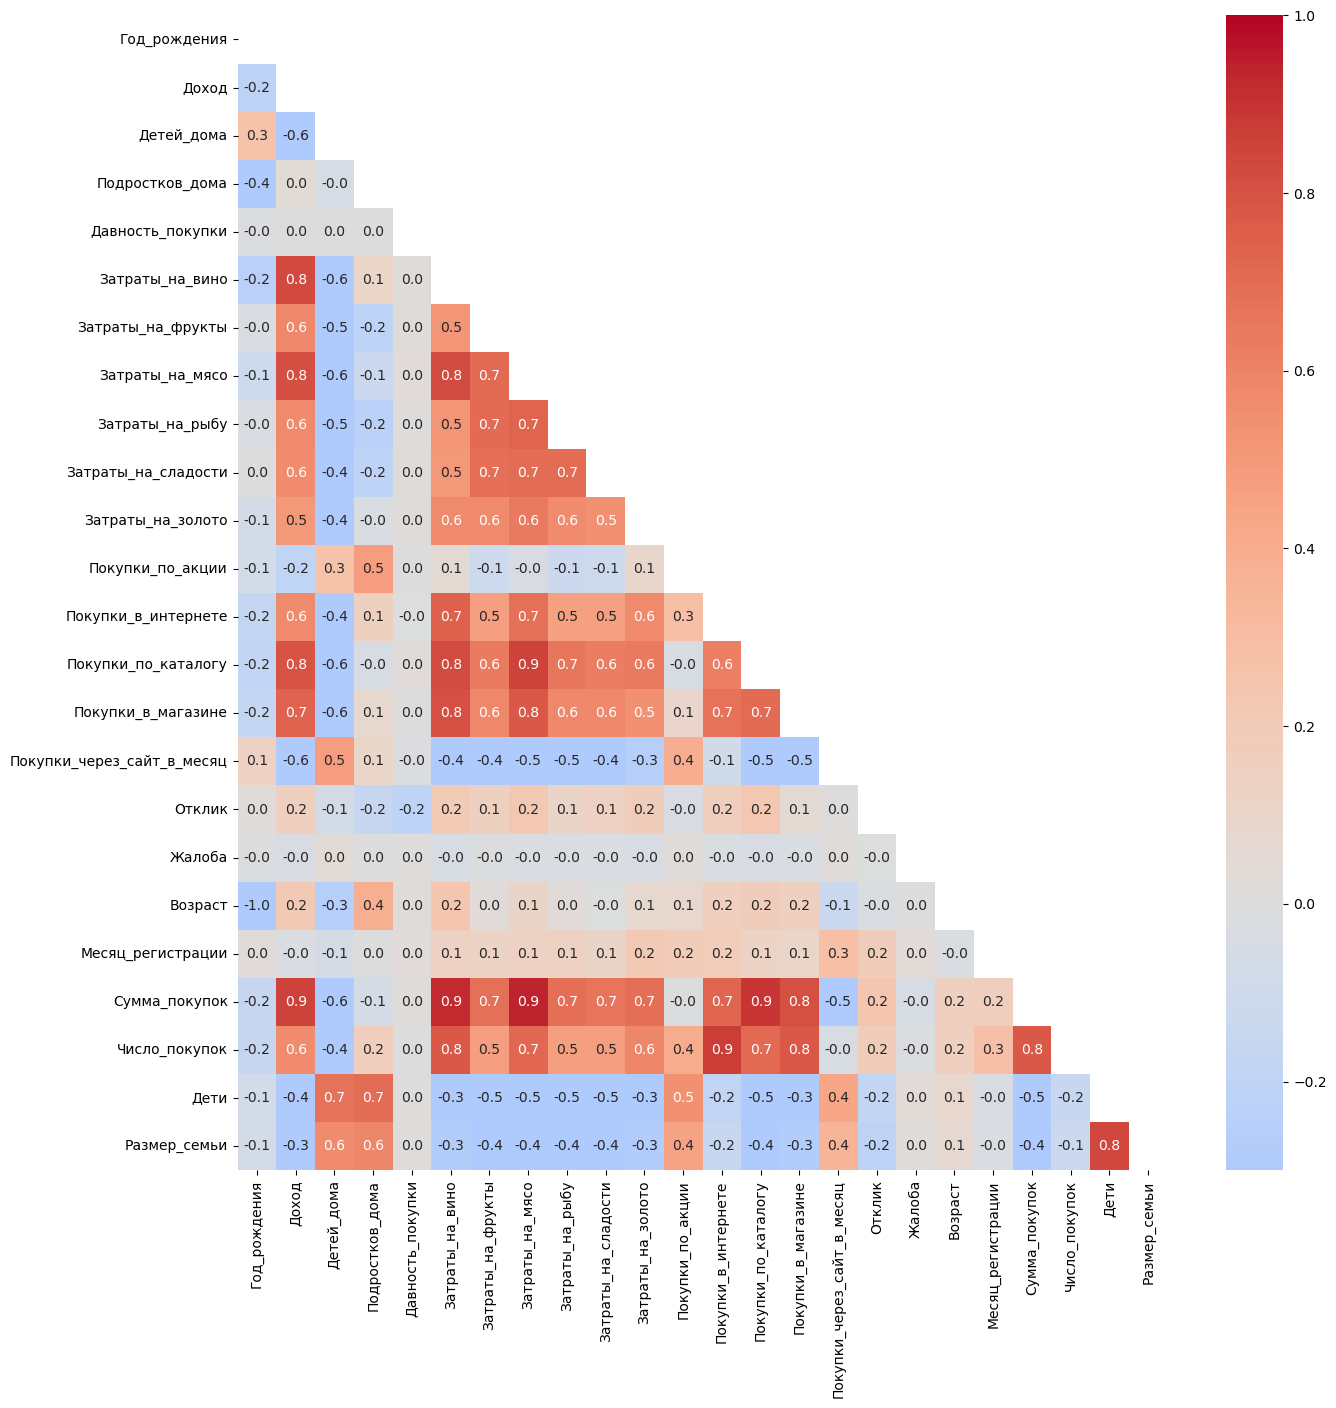

In [42]:
corr_df = df.select_dtypes(include=[np.number]).corr(method='spearman')
mask = np.triu(np.ones_like(corr_df, dtype=bool))

plt.figure(figsize=(15, 15))
sns.heatmap(corr_df, mask=mask, annot=True, fmt=".1f", vmin=-0.3, vmax=1, center=0, cmap="coolwarm")
plt.show()

In [43]:
cols_plot = [
    'Доход',                         # Income
    'Давность_покупки',              # Recency
    'Сумма_покупок',                 # Sum_Purchases
    'Число_покупок',                 # Count_Purchases
    'Возраст',                       # Age
    'Семейное положение и дети'      # Marital_Status_Children
]

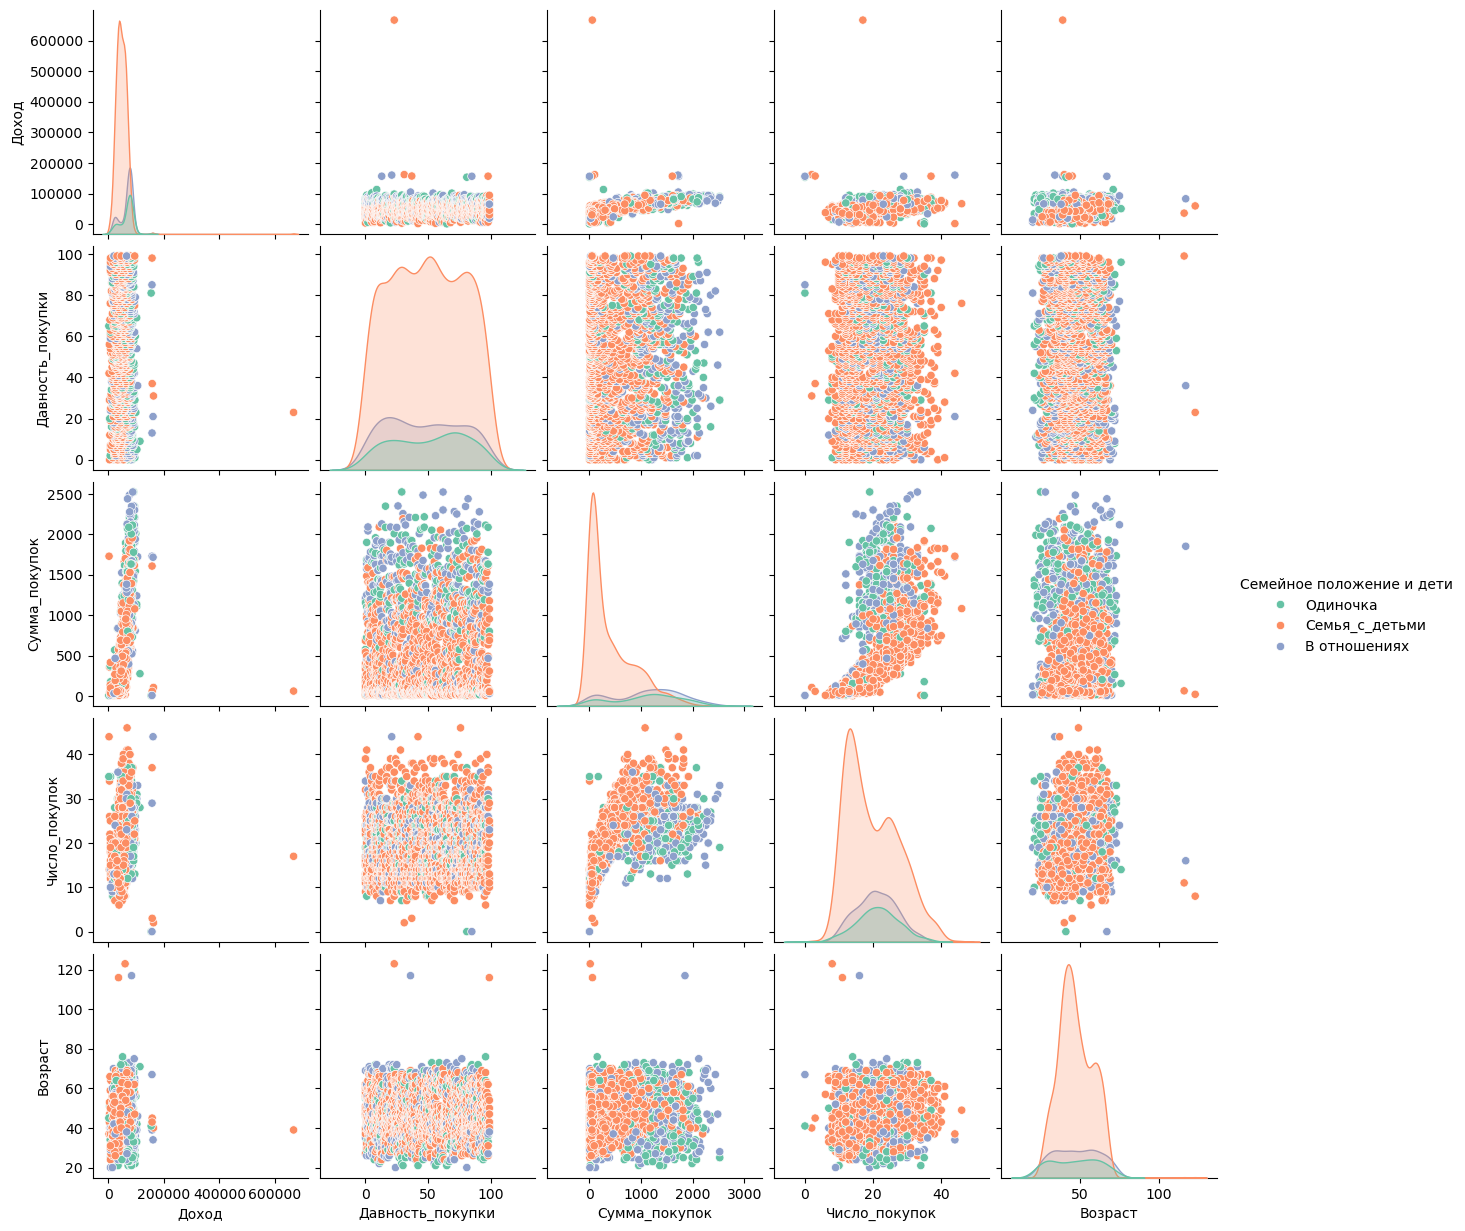

In [44]:
sns.pairplot(df[cols_plot], hue='Семейное положение и дети', palette='Set2')
plt.show()

In [45]:
#Выбросы в возрасте и доходах
df[cols_plot[:-1]].describe()

Доход  Давность_покупки  Сумма_покупок  Число_покупок  \
count    2216.000000       2216.000000    2216.000000    2216.000000   
mean    52247.251354         49.012635     607.075361      20.199910   
std     25173.076661         28.948352     602.900476       7.283193   
min      1730.000000          0.000000       5.000000       0.000000   
25%     35303.000000         24.000000      69.000000      14.000000   
50%     51381.500000         49.000000     396.500000      19.000000   
75%     68522.000000         74.000000    1048.000000      25.000000   
max    666666.000000         99.000000    2525.000000      46.000000   

           Возраст  
count  2216.000000  
mean     47.179603  
std      11.985554  
min      20.000000  
25%      39.000000  
50%      46.000000  
75%      57.000000  
max     123.000000

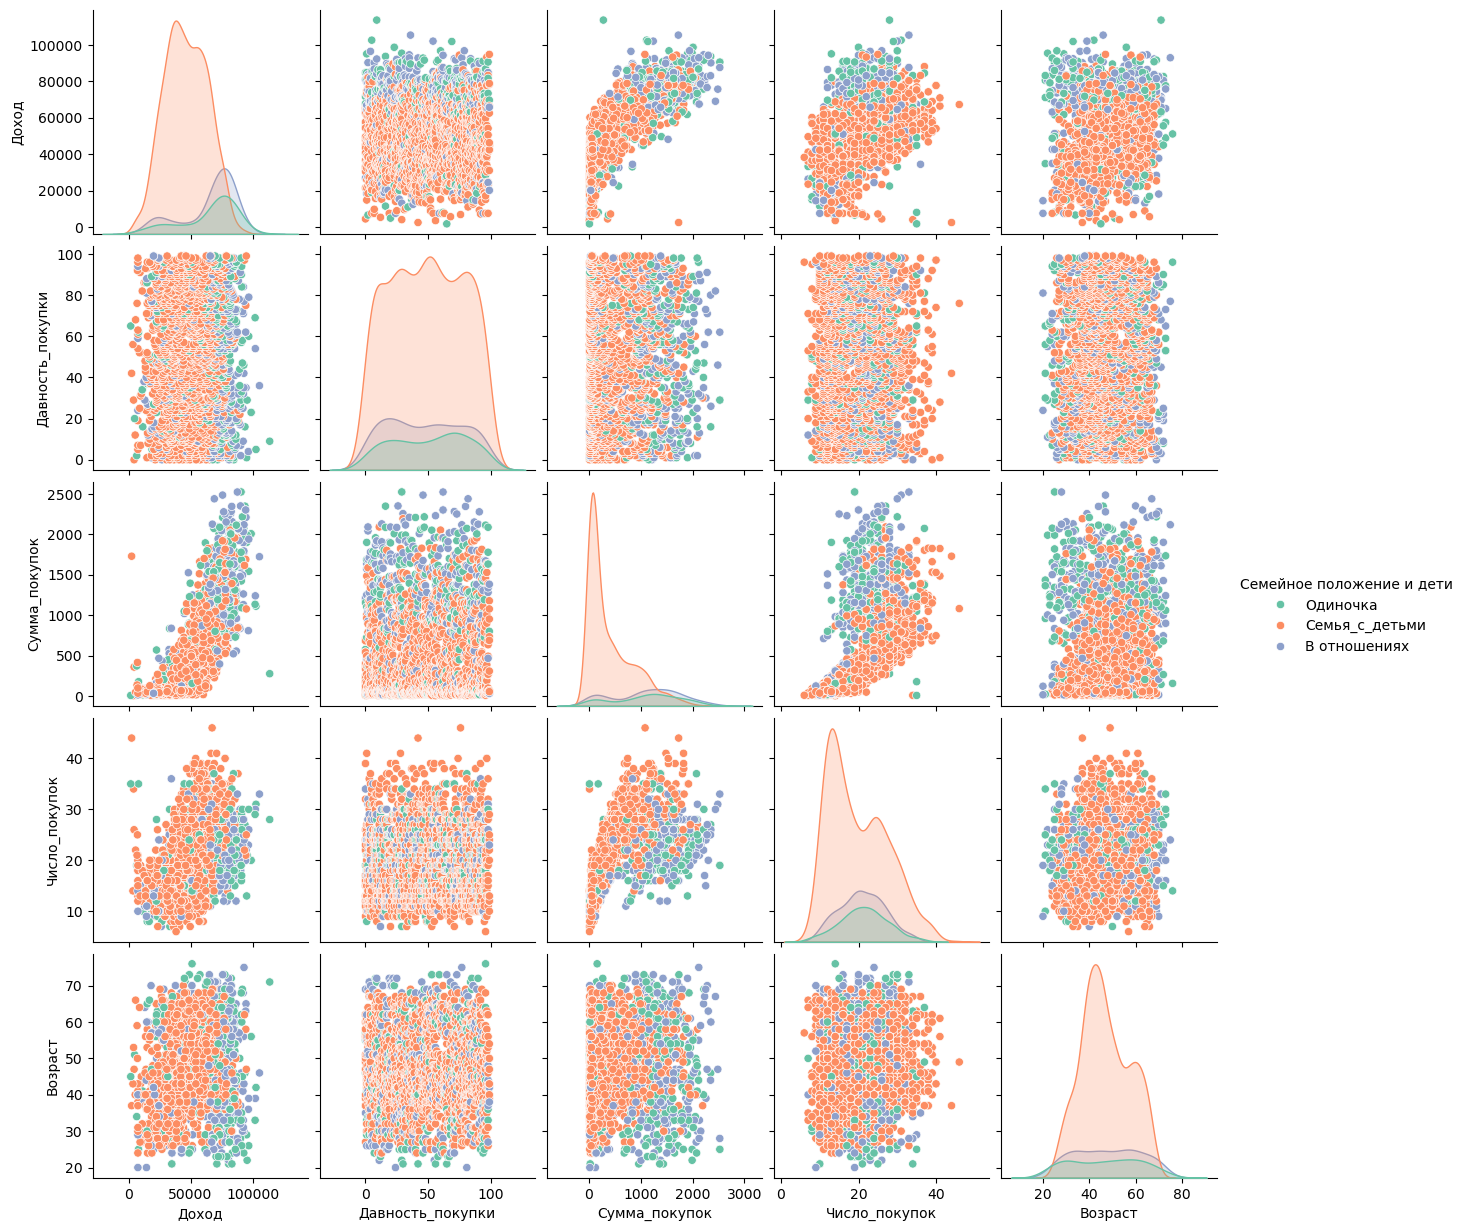

In [46]:
def remove_outliers(data: pd.DataFrame, column: str) -> pd.DataFrame:
    Q3, Q1 = np.nanpercentile(data[column], [75, 25])
    IQR = Q3 - Q1

    upper_bound = Q3 + 1.5 * IQR
    lower_bound = Q1 - 1.5 * IQR

    return data[(data[column] > lower_bound) & (data[column] < upper_bound)]

df = remove_outliers(data=df, column='Возраст')
df = remove_outliers(data=df, column='Доход')


sns.pairplot(df[cols_plot], hue="Семейное положение и дети", palette='Set2')
plt.show()

In [47]:
df_safe = df.copy()

In [48]:
df = df.drop(['Год_рождения', 'Дата_регистрации'], axis=1)


In [49]:
df_labels = pd.get_dummies(df)
df_labels.head()

Доход  Детей_дома  Подростков_дома  Давность_покупки  Затраты_на_вино  \
0  84835.0           0                0                 0              189   
1  57091.0           0                0                 0              464   
2  67267.0           0                1                 0              134   
3  32474.0           1                1                 0               10   
4  21474.0           1                0                 0                6   

   Затраты_на_фрукты  Затраты_на_мясо  Затраты_на_рыбу  Затраты_на_сладости  \
0                104              379              111                  189   
1                  5               64                7                    0   
2                 11               59               15                    2   
3                  0                1                0                    0   
4                 16               24               11                    0   

   Затраты_на_золото  ...  Образование_Аспирантура (PhD)  \
0                218  ...                          False   
1                 37  ...                          False   
2                 30  ...                          False   
3                  0  ...                          False   
4                 34  ...                          False   

   Образование_Высшее образование  Образование_Магистратура  \
0                            True                     False   
1                            True                     False   
2                            True                     False   
3                            True                     False   
4                            True                     False   

   Образование_Незаконченное высшее  Образование_Среднее образование  \
0                             False                            False   
1                             False                            False   
2                             False                            False   
3                             False                            False   
4                             False                            False   

   Семейное_положение_В отношениях  Семейное_положение_Одиночка  \
0                            False                         True   
1                            False                         True   
2                             True                        False   
3                             True                        False   
4                            False                         True   

   Семейное положение и дети_В отношениях  Семейное положение и дети_Одиночка  \
0                                   False                                True   
1                                   False                                True   
2                                   False                               False   
3                                   False                               False   
4                                   False                               False   

   Семейное положение и дети_Семья_с_детьми  
0                                     False  
1                                     False  
2                                      True  
3                                      True  
4                                      True  

[5 rows x 33 columns]

In [50]:
df['Доход'].describe()

count      2205.000000
mean      51622.094785
std       20713.063826
min        1730.000000
25%       35196.000000
50%       51287.000000
75%       68281.000000
max      113734.000000
Name: Доход, dtype: float64

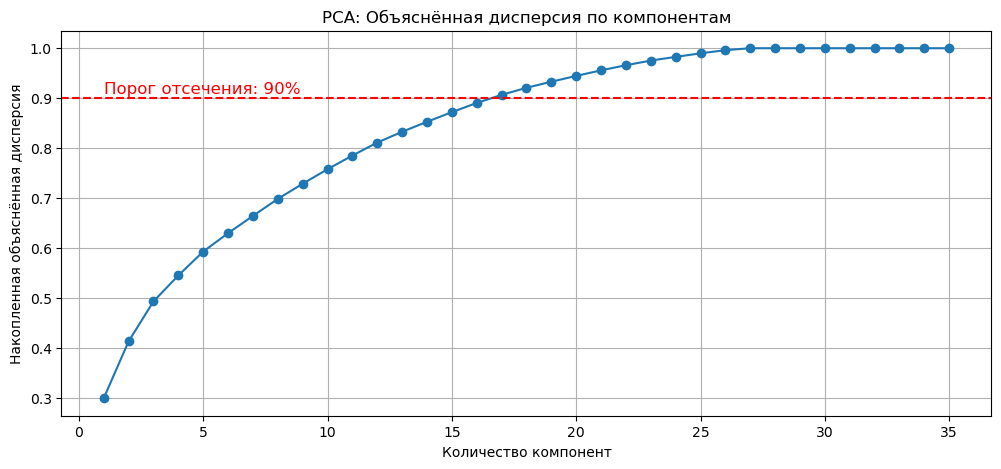

In [78]:
X_scaled = StandardScaler().fit_transform(df_labels)

pca = PCA().fit(X_scaled)

plt.figure(figsize=(12, 5))
x = np.arange(1, len(pca.explained_variance_ratio_) + 1)
plt.plot(x, np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='-')
plt.axhline(y=0.9, color='r', linestyle='--')
plt.text(1, 0.91, 'Порог отсечения: 90%', color='red', fontsize=12)
plt.xlabel('Количество компонент')
plt.ylabel('Накопленная объяснённая дисперсия')
plt.title('PCA: Объяснённая дисперсия по компонентам')
plt.grid(True)
plt.show()

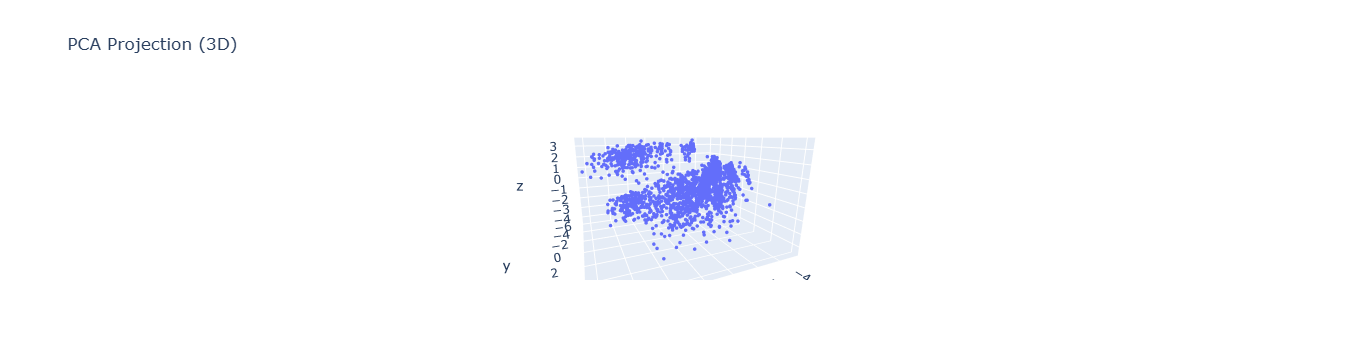

In [79]:
X_scaled = StandardScaler().fit_transform(df_labels)

pca = PCA(n_components=0.9, random_state=RAND)
X_embedding_pca = pca.fit_transform(X_scaled)


pca_3 = PCA(n_components=3, random_state=RAND)
X_embedding_pca_3 = pca_3.fit_transform(X_scaled)


fig = px.scatter_3d(
    x=X_embedding_pca_3[:, 0],
    y=X_embedding_pca_3[:, 1],
    z=X_embedding_pca_3[:, 2],
    labels={'color': 'Тип семьи'},
    title='PCA Projection (3D)'
)
fig.update_traces(marker=dict(size=2))
fig.show()

In [53]:
explained_variance = pca.explained_variance_ratio_
explained_variance

array([0.27959936, 0.11262111, 0.08259967, 0.05505621, 0.05058195,
       0.03887594, 0.03642447, 0.03569754, 0.03177925, 0.03071132,
       0.02910064, 0.02680249, 0.02130018, 0.02066217, 0.01988807,
       0.01948627, 0.01706288])

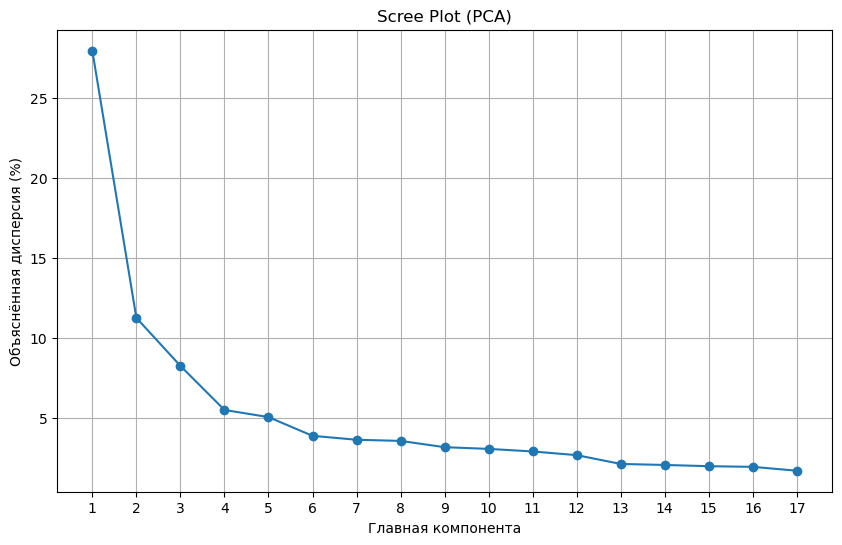

In [54]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance)+1), explained_variance * 100, marker='o', linestyle='-')
plt.title('Scree Plot (PCA)')
plt.xlabel('Главная компонента')
plt.ylabel('Объяснённая дисперсия (%)')
plt.grid(True)
plt.xticks(range(1, len(explained_variance)+1))
plt.show()

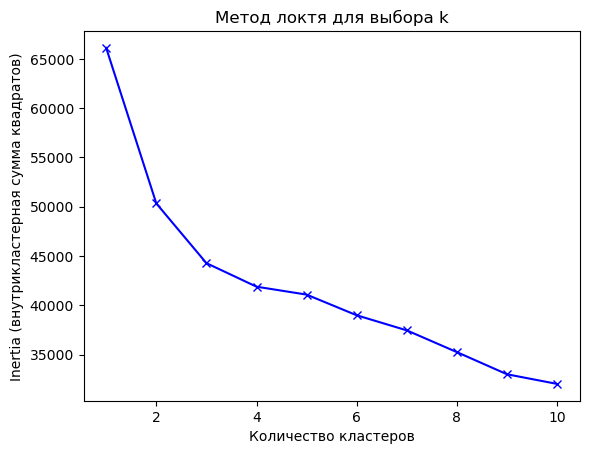

In [55]:
inertia = []
K = range(1, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_embedding_pca)  # X_pca — данные после PCA
    inertia.append(kmeans.inertia_)

plt.plot(K, inertia, 'bx-')
plt.xlabel('Количество кластеров')
plt.ylabel('Inertia (внутрикластерная сумма квадратов)')
plt.title('Метод локтя для выбора k')
plt.show()

In [67]:
X = X_embedding_pca

NUM_CLUSTERS = 4
kmeans = KMeans(n_clusters=NUM_CLUSTERS, random_state=RAND, n_init=10)
labels = kmeans.fit_predict(X)

df_labels['Кластер'] = labels

sil_score = silhouette_score(X, labels)
db_index = davies_bouldin_score(X, labels)

print(f"Silhouette Score: {sil_score:.4f}")
print(f"Davies-Bouldin Index: {db_index:.4f}")

Silhouette Score: 0.2021
Davies-Bouldin Index: 1.7032


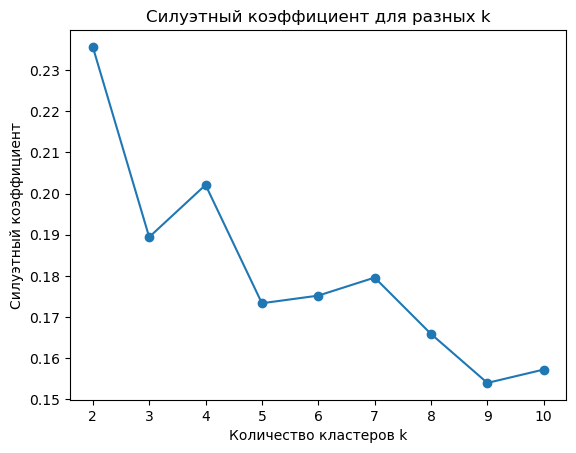

In [68]:
silhouette_scores = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=RAND, n_init=10)
    labels = kmeans.fit_predict(X)
    score = silhouette_score(X, labels)
    silhouette_scores.append(score)

plt.plot(K, silhouette_scores, marker='o')
plt.xlabel('Количество кластеров k')
plt.ylabel('Силуэтный коэффициент')
plt.title('Силуэтный коэффициент для разных k')
plt.show()


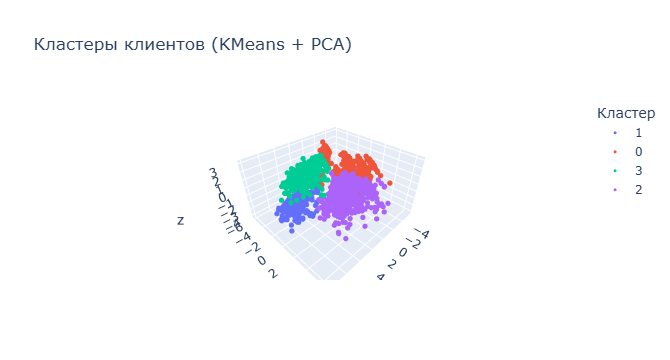

In [69]:
fig = px.scatter_3d(
    x=X_embedding_pca_3[:, 0],
    y=X_embedding_pca_3[:, 1],
    z=X_embedding_pca_3[:, 2],
    color=df_labels['Кластер'].astype(str),  # <- передаём именно этот столбец
    labels={'color': 'Кластер'},
    title='Кластеры клиентов (KMeans + PCA)'
)
fig.update_traces(marker=dict(size=3))
fig.show()


In [73]:
df.head()

Образование Семейное_положение    Доход  Детей_дома  \
0  Высшее образование           Одиночка  84835.0           0   
1  Высшее образование           Одиночка  57091.0           0   
2  Высшее образование       В отношениях  67267.0           0   
3  Высшее образование       В отношениях  32474.0           1   
4  Высшее образование           Одиночка  21474.0           1   

   Подростков_дома  Давность_покупки  Затраты_на_вино  Затраты_на_фрукты  \
0                0                 0              189                104   
1                0                 0              464                  5   
2                1                 0              134                 11   
3                1                 0               10                  0   
4                0                 0                6                 16   

   Затраты_на_мясо  Затраты_на_рыбу  ...  Покупки_через_сайт_в_месяц  Отклик  \
0              379              111  ...                           1       1   
1               64                7  ...                           5       1   
2               59               15  ...                           2       0   
3                1                0  ...                           7       0   
4               24               11  ...                           7       1   

   Жалоба  Возраст  Месяц_регистрации  Сумма_покупок  Число_покупок  Дети  \
0       0       46                 30           1190             16     0   
1       0       55                 30            577             23     0   
2       0       58                 31            251             13     1   
3       0       49                 25             11             11     2   
4       0       27                 28             91             15     1   

   Размер_семьи  Семейное положение и дети  
0             1                   Одиночка  
1             1                   Одиночка  
2             3             Семья_с_детьми  
3             4             Семья_с_детьми  
4             2             Семья_с_детьми  

[5 rows x 26 columns]

In [71]:
cluster_summary = df_labels.groupby('Кластер').agg(['mean', 'median', 'count'])
cluster_summary


Доход                Детей_дома              Подростков_дома  \
                 mean   median count       mean median count            mean   
Кластер                                                                        
0        34828.633721  34716.0  1032   0.796512    1.0  1032        0.478682   
1        71763.529680  74293.0   219   0.004566    0.0   219        0.000000   
2        61160.080997  61300.0   642   0.235202    0.0   642        0.970405   
3        73405.717949  75633.0   312   0.003205    0.0   312        0.000000   

                     Давность_покупки  ...  \
        median count             mean  ...   
Кластер                                ...   
0          0.0  1032        49.069767  ...   
1          0.0   219        52.118721  ...   
2          1.0   642        48.640187  ...   
3          0.0   312        47.384615  ...   

        Семейное положение и дети_В отношениях  \
                                         count   
Кластер                                          
0                                         1032   
1                                          219   
2                                          642   
3                                          312   

        Семейное положение и дети_Одиночка               \
                                      mean median count   
Кластер                                                   
0                                 0.031977    0.0  1032   
1                                 0.995434    1.0   219   
2                                 0.000000    0.0   642   
3                                 0.000000    0.0   312   

        Семейное положение и дети_Семья_с_детьми              Cluster         \
                                            mean median count    mean median   
Кластер                                                                        
0                                       0.904070    1.0  1032     0.0    0.0   
1                                       0.004566    0.0   219     1.0    1.0   
2                                       1.000000    1.0   642     2.0    2.0   
3                                       0.003205    0.0   312     3.0    3.0   

               
        count  
Кластер        
0        1032  
1         219  
2         642  
3         312  

[4 rows x 102 columns]

In [72]:
### Анализ 


In [64]:
def generate_recommendation(row):
    if row['Доход'] > 70000 and row['Возраст'] < 40:
        return "Предложить премиальные товары, использовать email-рассылку и персональные предложения."
    elif row['Дети'] > 0 and row['Размер_семьи'] >= 3:
        return "Фокус на семейные товары, скидки на детские категории, продвижение через соцсети для родителей."
    elif row['Сумма_покупок'] < 100:
        return "Мотивационные предложения: бесплатная доставка, welcome-бонус, рассылки с ограниченными акциями."
    elif row['Давность_покупки'] > 60:
        return "Активировать ретаргетинг: напоминания о бренде, предложения для возврата клиента."
    else:
        return "Универсальная программа лояльности и рекомендации на основе популярного спроса."

In [76]:
for cluster_id, cluster_data in df_labels.groupby('Кластер'):
    profile = cluster_data.mean(numeric_only=True).to_dict()
    print(f"Кластер {cluster_id}: {generate_recommendation(profile)}")

Кластер 0: Мотивационные предложения: бесплатная доставка, welcome-бонус, рассылки с ограниченными акциями.
Кластер 1: Универсальная программа лояльности и рекомендации на основе популярного спроса.
Кластер 2: Универсальная программа лояльности и рекомендации на основе популярного спроса.
Кластер 3: Универсальная программа лояльности и рекомендации на основе популярного спроса.


Основывая на метриках, я могу сделать вывод, что 4 кластера лучше всего отражают соц-дем.
Кластер 0 и 2 отлично отделили семьи с подростками и высоким доходом в отделбную группу. 
2 кластер расчитан на премиальный сегмент семейных товаром и товаров для подростков
Что при 3 кластерах было бы нам недоступно. они сливаюся в один.

Кластер 0: "Семьи с детьми, средний доход"
Доход: Средний (~34,8K), ближе к медианному значению по выборке.
Дети: В основном есть маленькие дети (в среднем 0.8), реже подростки (0.48)
Семейное положение: Преимущественно семьи с детьми (90.4%), реже одиночки (3.2%) или пары без детей (6.4%).
Активность (Recency): Средняя (последняя покупка ~49 дней назад).
Особенности: Самый многочисленный кластер (1032 клиента), вероятно, основная целевая аудитория для семейных товаров.


Кластер 1: "Высокодоходные одиночки"
Доход: Очень высокий (~71,8K), самый высокий среди кластеров.
Дети: Практически нет (почти 0 детей и подростков).
Семейное положение: Почти все клиенты — одиночки (99.5%).
Активность: Чуть менее активны (последняя покупка ~52 дня назад).
Особенности: Маленький кластер (219 клиентов), подходит для премиум-товаров и услуг.


Кластер 2: "Семьи с подростками, доход выше среднего"
Доход: Выше среднего (~61,2K).
Дети: Мало маленьких детей (0.24), но почти в каждом домохозяйстве есть подростки (0.97).
Семейное положение: Все клиенты — семьи с детьми (100%).
Активность: Достаточно активны (последняя покупка ~48.6 дней назад).
Особенности: Средний по размеру кластер (642 клиента), могут быть целевой аудиторией для товаров для подростков.

Кластер 3: "Высокодоходные пары без детей"
Доход: Очень высокий (~73,4K), сопоставим с Кластером 1.
Дети: Почти нет (0.003 маленьких детей и 0 подростков).
Семейное положение: Практически все состоят в отношениях без детей (99.7%).
Активность: Наиболее активные (последняя покупка ~47.4 дня назад).
Особенности: Подходят для товаров класса "люкс" и предложений для пар.

In [77]:
descriptions = {
    0: """Кластер 0: Семьи с детьми, средний доход.
Доход ~34,8K. Есть маленькие дети. Семейное положение — в основном семьи с детьми.
Рекомендация: Рекламировать товары для дома, детей и семейный досуг. Использовать email, скидки, соцсети родителей.""",
    
    1: """Кластер 1: Высокодоходные одиночки.
Доход ~71,8K. Почти нет детей. Почти все — одиночки.
Рекомендация: Персонализированные предложения премиум-класса. Использовать email, push, VIP-акции.""",
    
    2: """Кластер 2: Семьи с подростками, доход выше среднего.
Доход ~61,2K. В основном есть подростки.
Рекомендация: Промо на гаджеты, подростковую моду и курсы. Таргетинг в Instagram и TikTok.""",
    
    3: """Кластер 3: Высокодоходные пары без детей.
Доход ~73,4K. Почти все — пары без детей.
Рекомендация: Реклама товаров класса люкс, путешествий, дизайна. Стильная рассылка, предложения для пар."""
}

with open("кластерные_рекомендации.txt", "w", encoding="utf-8") as f:
    for cluster_id in sorted(descriptions):
        f.write(descriptions[cluster_id] + "\n\n")

print("✅ Рекомендации сохранены в файл 'кластерные_рекомендации.txt'")

✅ Рекомендации сохранены в файл 'кластерные_рекомендации.txt'


### ТЕСТЫ ДРУГИХ Методов


KMeans: Silhouette Score = 0.2209, Davies-Bouldin Index = 1.6880


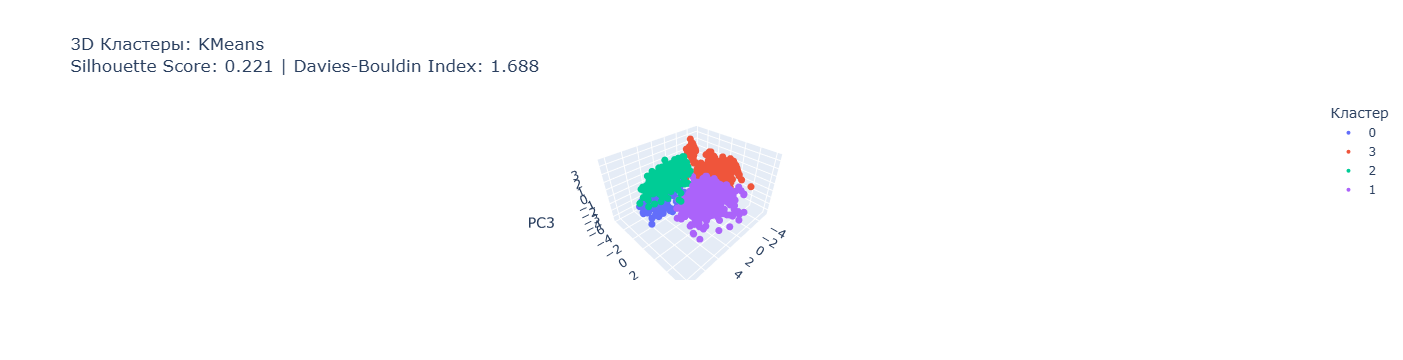

Agglomerative: Silhouette Score = 0.2115, Davies-Bouldin Index = 1.7102


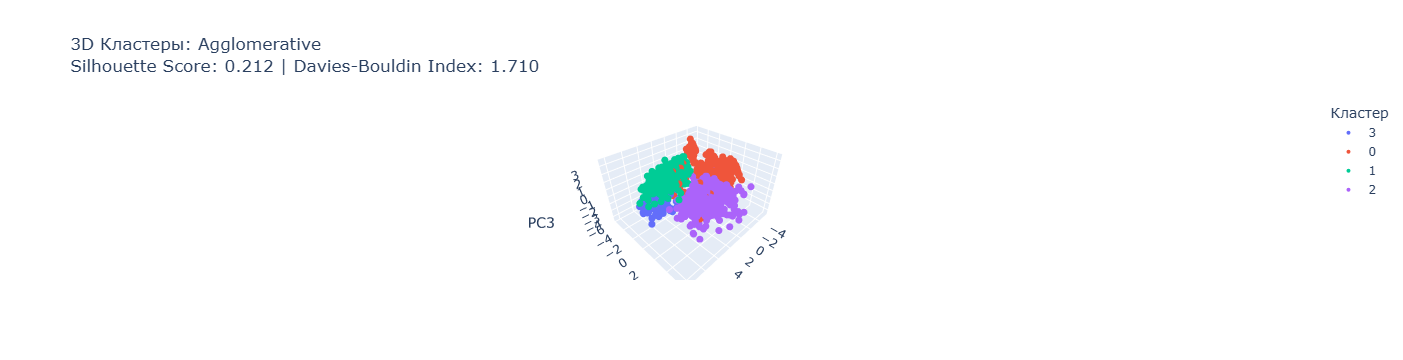

Spectral: Silhouette Score = 0.2099, Davies-Bouldin Index = 1.4694


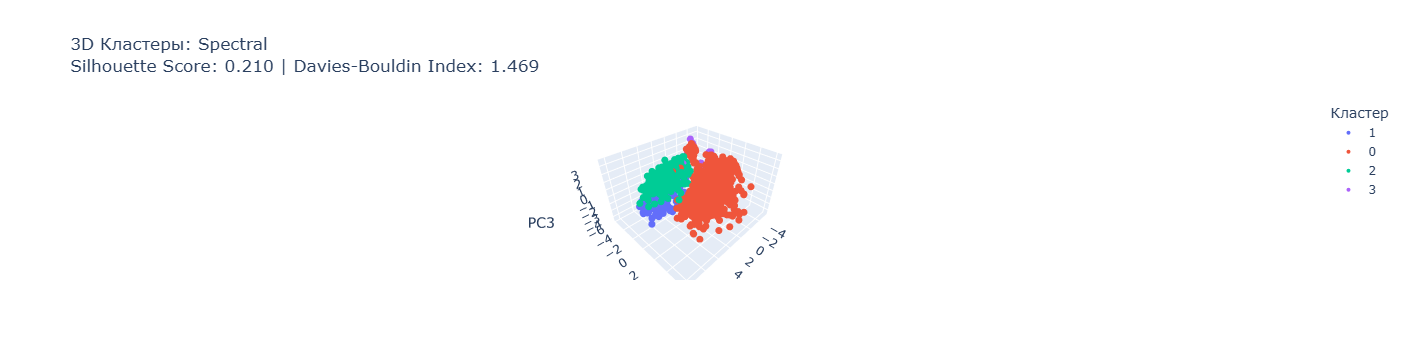

In [82]:
import plotly.express as px
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score
import pandas as pd

X = X_scaled

pca_3 = PCA(n_components=3, random_state=RAND)
X_pca_3 = pca_3.fit_transform(X)

models = {
    'KMeans': KMeans(n_clusters=4, random_state=RAND, n_init=10),
    'Agglomerative': AgglomerativeClustering(n_clusters=4),
    'Spectral': SpectralClustering(n_clusters=4, affinity='nearest_neighbors', n_neighbors=30, random_state=RAND)
}

for name, model in models.items():
    labels = model.fit_predict(X)

    sil_score = silhouette_score(X, labels)
    db_index = davies_bouldin_score(X, labels)

    print(f'{name}: Silhouette Score = {sil_score:.4f}, Davies-Bouldin Index = {db_index:.4f}')  # ← вот это добавлено

    df_plot = pd.DataFrame({
        'PC1': X_pca_3[:, 0],
        'PC2': X_pca_3[:, 1],
        'PC3': X_pca_3[:, 2],
        'Cluster': labels.astype(str)
    })

    fig = px.scatter_3d(
        df_plot, x='PC1', y='PC2', z='PC3',
        color='Cluster',
        title=(
            f'3D Кластеры: {name}<br>'
            f'Silhouette Score: {sil_score:.3f} | '
            f'Davies-Bouldin Index: {db_index:.3f}'
        ),
        labels={'Cluster': 'Кластер'}
    )
    fig.update_traces(marker=dict(size=4))
    fig.show()

In [83]:
from pathlib import Path
from nbformat import read

# Загрузим и прочитаем содержимое Jupyter Notebook
notebook_path = Path("Untitled.ipynb")
with notebook_path.open("r", encoding="utf-8") as f:
    nb = read(f, as_version=4)

# Извлечем весь текст и код из ноутбука
notebook_content = ""
for cell in nb.cells:
    if cell.cell_type == "markdown":
        notebook_content += cell.source + "\n\n"
    elif cell.cell_type == "code":
        notebook_content += "```python\n" + cell.source + "\n```\n\n"

notebook_content[:3000]  # Покажем первые 3000 символов для анализа

'Response — 1, если клиент принял предложение в последней кампании, 0 — в противном случае\nID — уникальный идентификатор каждого клиента\nYear_Birth — возраст клиента\nComplain — 1, если клиент жаловался в течение последних 2 лет\nDt_Customer — дата регистрации клиента в компании\nEducation — уровень образования клиента\nMarital — семейное положение клиента\nKidhome — количество маленьких детей в семье клиента\nTeenhome — количество подростков в семье клиента\nIncome — годовой доход семьи клиента\nMntFishProducts — сумма, потраченная на рыбные продукты за последние 2 года\nMntMeatProducts — сумма, потраченная на мясные продукты за последние 2 года\nMntFruits — сумма, потраченная на фрукты за последние 2 года\nMntSweetProducts — сумма, потраченная на сладости за последние 2 года\nMntWines — сумма, потраченная на вино за последние 2 года\nMntGoldProds — сумма, потраченная на изделия из золота за последние 2 года\nNumDealsPurchases — количество покупок, совершенных со скидкой\nNumCatalog